In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cmdstanpy as csp
import numpy as np
import pandas as pd
import logging
import warnings
from tqdm import tqdm

In [2]:
# Handling warnings and logging
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", module="plotnine\..*")
csp.utils.get_logger().setLevel(logging.ERROR)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
def rating_csv_to_dict(file):
    df = pd.read_csv(file, comment='#')
    rater = df['rater'].to_list()
    item = df['item'].to_list()
    rating = df['rating'].to_list()
    I = int(np.max(item))
    J = int(np.max(rater))
    N = int(len(rater))
    data = {'I': I, 'J': J, 'N': N, 'item': item, 'rater': rater, 'rating': rating}
    return data

def sample(stan_file, data, init={}):
    model = csp.CmdStanModel(stan_file=stan_file)
    return model.sample(data=data, inits=init, iter_warmup=1000, iter_sampling=1000, chains=2, parallel_chains=4, show_console=False, show_progress=False, refresh=100, seed=925845)


In [7]:
# Data loading and initialization
data_file = 'rte.csv'
data_path = '../data/' + data_file
data = rating_csv_to_dict(data_path)
init = {
    'pi': 0.2,
    'alpha_acc_scalar': 2,
    'alpha_sens_scalar': 1,
    'alpha_spec_scalar': 2,
    'alpha_acc': np.full(data['J'], 2),
    'alpha_sens': np.full(data['J'], 1),
    'alpha_spec': np.full(data['J'], 2),
    'beta': np.full(data['I'], 0),
    'delta': np.full(data['I'], 1),
    'lambda': np.full(data['I'], 0.5)
}    

In [8]:
votes = {}
rater = {}
models = ['a', 'ab', 'abc','full']  # 'abc' is the Dawid & Skene model
# Running each model and storing the posterior mean votes
for model in tqdm(models, desc="Processing Models"):
    draws = sample(f'../stan/{model}.stan', data, init)
    votes_sim = draws.stan_variable('votes_sim')
    rater_sim = draws.stan_variable('rater_sim')
    
    # Calculate posterior mean for each model and store it
    mean_votes = np.mean(votes_sim, axis=0)  
    mean_raters = np.mean(rater_sim, axis=0)  
    votes[model] = mean_votes
    rater[model] = mean_raters

Processing Models: 100%|█████████████████████████████████████████████████████████████| 4/4 [09:29<00:00, 142.34s/it]


In [44]:
print(rater['abc'].shape)
rater['abc']

(164,)


array([583.3795, 111.6135,   9.924 ,  11.682 ,  18.5265,   9.707 ,
         4.884 ,  18.5295, 130.7085,  18.3185,  23.659 ,   8.0845,
        47.0455,  10.1855, 652.094 ,  24.1935,  23.855 ,  24.372 ,
        10.159 ,   8.2155,   9.706 ,   9.745 ,   8.916 ,   9.743 ,
         9.0955,  54.796 ,   8.8965,   9.152 ,   9.73  ,  10.3055,
         8.6335,   7.992 ,   8.908 ,   9.702 ,   7.6145,   9.5325,
         9.809 ,   8.3045,   8.303 ,  13.1385,  19.9575,   9.5525,
         6.8795,  30.572 , 407.6095,   9.7305,   7.6385,  10.2085,
        20.6255,  32.1535,  11.3365,   8.674 ,   9.116 ,   8.9505,
        12.079 ,  14.7685,   4.087 ,  10.5485,  10.2545,  31.5775,
         9.847 ,   8.357 ,   5.062 ,  22.8415,  11.389 ,   9.1745,
        11.012 ,   8.7165,  16.9625,   9.723 ,  30.1405,   9.6875,
         8.4265,  12.843 ,  35.738 ,   9.2545,  11.378 ,  10.3405,
        31.464 ,   9.1055,   9.0295,  10.7425,   3.157 ,  18.236 ,
        16.513 ,   9.667 ,  23.1595,   9.9055,   7.272 ,  11.9

In [42]:
print(rater['full'].shape)
rater['full']

(164,)


array([516.448 , 101.981 ,  10.4595,  10.939 ,  17.5145,   9.1145,
         6.6715,  17.7135, 128.691 ,  17.7975,  22.4095,   7.8055,
        45.3475,   9.738 , 568.466 ,  22.9585,  23.198 ,  23.3625,
        10.395 ,   8.574 ,  10.2905,  10.305 ,   7.5205,   9.8265,
         8.8795,  54.6345,   9.3125,   9.514 ,  10.234 ,  10.534 ,
         8.9845,   7.6045,   8.998 ,  10.1065,   8.269 ,   9.852 ,
        10.0815,   8.8455,   8.3925,  12.3365,  19.772 ,   9.795 ,
         7.1375,  29.938 , 362.0125,  10.307 ,   8.0735,  10.732 ,
        20.5165,  27.829 ,  11.1675,   8.1805,   9.295 ,   9.1085,
        10.897 ,  14.527 ,   5.9925,  10.3065,  10.0995,  31.701 ,
         9.346 ,   8.4   ,   6.312 ,  23.486 ,   9.7925,   9.717 ,
        10.5825,   8.997 ,  14.873 ,  10.3085,  28.7435,   9.647 ,
         8.5995,  12.5635,  36.759 ,   9.419 ,  10.8875,  10.1895,
        29.523 ,   8.916 ,   9.192 ,  10.0575,   5.5105,  15.144 ,
        17.6765,   9.7165,  22.0055,  10.2725,   7.621 ,  10.0

In [17]:
print(votes['abc'].shape)
votes['abc']

(165,)


array([  2.2245,  21.5155,  75.6405, 124.5395, 110.625 ,  63.0375,
        46.8025,  75.8225, 117.639 , 113.073 ,  49.0805,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0. 

In [77]:
print(votes['full'].shape)
votes['full']

(165,)


array([ 47.613 ,  81.3185,  92.1685,  79.9845,  57.276 ,  42.014 ,
        44.1935,  62.7505,  88.564 , 108.414 ,  95.7035,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0. 

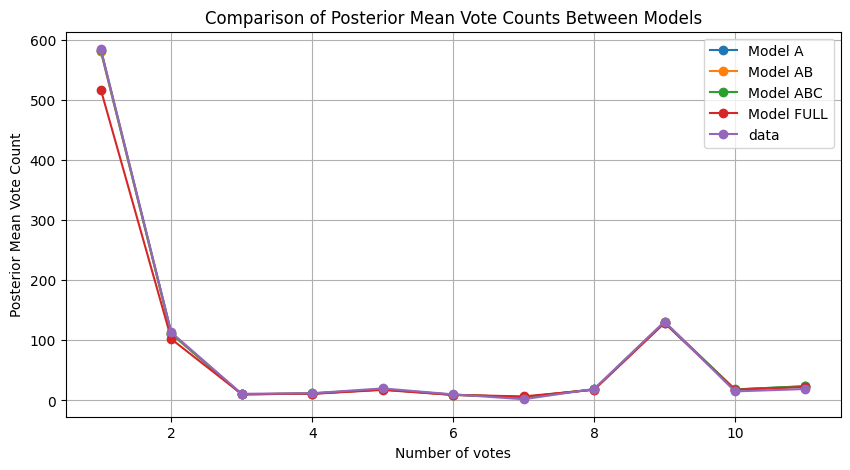

In [76]:
items = np.arange(1, len(actual_votes) + 1)   # Ensure items start at 1

# Assuming actual_votes needs to include an index from 1 to the end

# Now plot with the adjusted index
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(items[:11], rater[model][:11], label=f'Model {model.upper()}', marker='o')
plt.plot(items[:11], actual_votes[:11], label='data', marker='o')

plt.xlabel('Number of votes')
plt.ylabel('Posterior Mean Vote Count')
plt.title('Comparison of Posterior Mean Vote Counts Between Models')
plt.legend()
plt.grid(True)
plt.show()

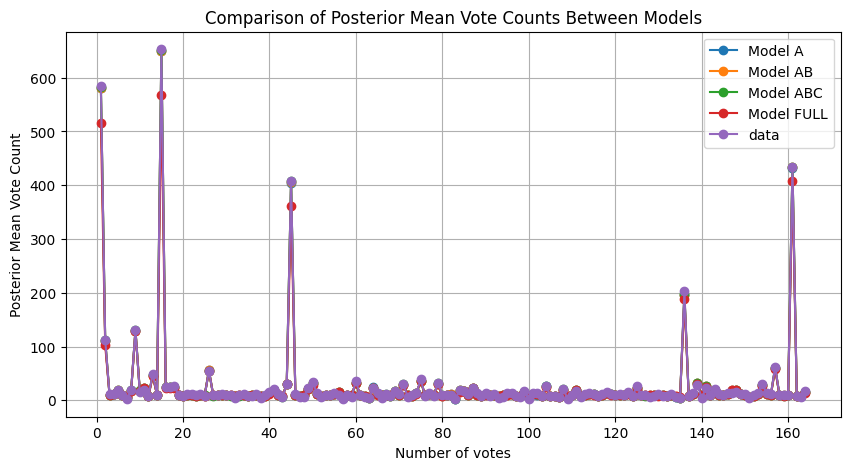

In [75]:
items = np.arange(1, len(actual_votes) + 1)   # Ensure items start at 1

# Assuming actual_votes needs to include an index from 1 to the end

# Now plot with the adjusted index
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(items, rater[model], label=f'Model {model.upper()}', marker='o')
plt.plot(items, actual_votes, label='data', marker='o')

plt.xlabel('Number of votes')
plt.ylabel('Posterior Mean Vote Count')
plt.title('Comparison of Posterior Mean Vote Counts Between Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
actual_votes2 = df2.groupby('item')['rating'].sum()
plt.plot(actual_votes2)

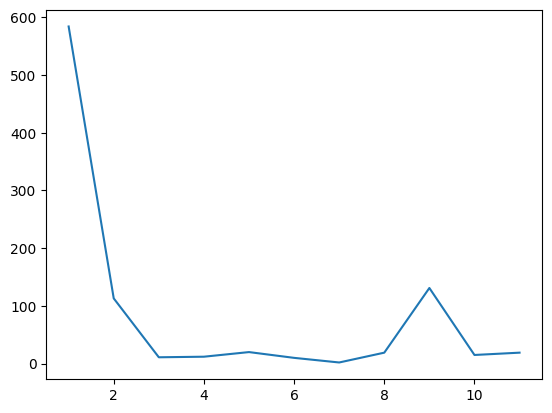

In [27]:
plt.plot(actual_votes[:11])

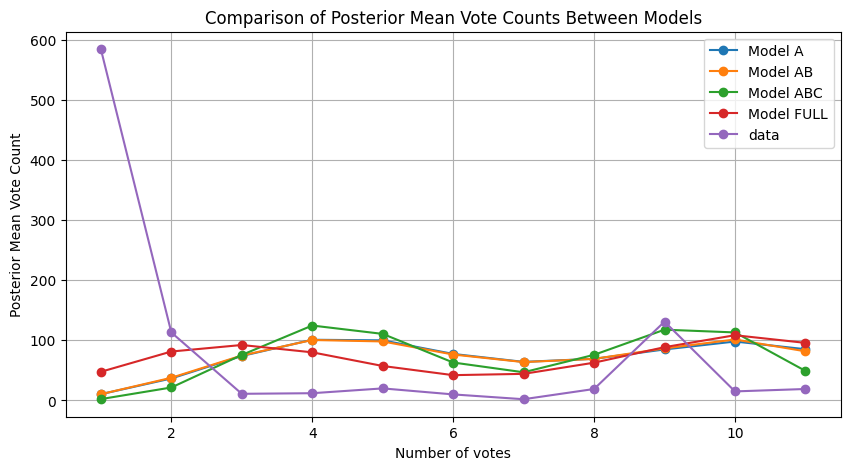

In [36]:
items = np.arange(1, len(votes['a']) + 1)  # Assuming all models have the same number of items
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(items[:11], votes[model][:11], label=f'Model {model.upper()}', marker='o')
plt.plot(items[:11], actual_votes.iloc[:11], label='data' , marker='o')
plt.xlabel('Number of votes')
plt.ylabel('Posterior Mean Vote Count')
plt.title('Comparison of Posterior Mean Vote Counts Between Models')
plt.legend()
plt.grid(True)
plt.show()